## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample

from itertools import chain
from random import sample 
import scipy
import sklearn.model_selection as skl
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(300)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
102230,00027213_060.png,Edema|Infiltration|Pneumonia|Pneumothorax,60,27213,73,F,AP,3056,2544,0.139,0.139,NaN,/data/images_011/images/00027213_060.png
53090,00013391_006.png,Infiltration,6,13391,45,F,PA,2544,2964,0.139,0.139,NaN,/data/images_006/images/00013391_006.png
84077,00020672_001.png,No Finding,1,20672,15,F,PA,2612,2403,0.143,0.143,NaN,/data/images_009/images/00020672_001.png
10405,00002701_007.png,Atelectasis|Consolidation,7,2701,54,F,PA,2992,2991,0.143,0.143,NaN,/data/images_002/images/00002701_007.png
46978,00011973_015.png,Pneumonia,15,11973,62,M,PA,2822,2991,0.143,0.143,NaN,/data/images_006/images/00011973_015.png
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13216,00003435_000.png,No Finding,0,3435,61,M,PA,2992,2991,0.143,0.143,NaN,/data/images_002/images/00003435_000.png
69135,00017056_001.png,No Finding,1,17056,56,F,PA,2538,2621,0.143,0.143,NaN,/data/images_008/images/00017056_001.png
89315,00022174_001.png,Atelectasis|Infiltration,1,22174,4,M,AP,2544,3056,0.139,0.139,NaN,/data/images_010/images/00022174_001.png
89833,00022309_005.png,No Finding,5,22309,36,F,AP,3056,2544,0.139,0.139,NaN,/data/images_010/images/00022309_005.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(13)

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
82700,00020326_050.png,No Finding,50,20326,27,F,AP,3024,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
58305,00014414_014.png,Infiltration,14,14414,53,M,PA,2572,2291,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
48745,00012364_012.png,No Finding,12,12364,52,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
827,00000201_001.png,No Finding,1,201,72,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
26208,00006875_027.png,Cardiomegaly,27,6875,57,F,PA,2254,2565,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
66259,00016397_001.png,No Finding,1,16397,44,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
54373,00013648_019.png,Mass,19,13648,34,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
59400,00014677_001.png,No Finding,1,14677,42,F,PA,2514,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16849,00004525_004.png,Atelectasis|Pneumothorax,4,4525,62,F,PA,2562,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83966,00020642_000.png,No Finding,0,20642,50,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo
all_xray_df['img_path'] = ImageDataGenerator(rescale=1. / 255.0,
                          horizontal_flip =True , 
                              vertical_flip =False , 
                              height_shift_range = 0.33, 
                              width_shift_range = 0.24, 
                              rotation_range = 20 , 
                              shear_range = 0.22 ,
                              zoom_range= 0.13
                        )


all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda x: int(x))
IMG_SIZE = (224, 224)

all_xray_df['pneumonia_class'] = all_xray_df['pneumonia_class'].astype(str)
#let's look at how a sample image looks like 

all_xray_df.sample(6)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path,pneumonia_class
34635,00009124_000.png,No Finding,0,9124,27,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
21570,00005742_002.png,Atelectasis,2,5742,60,M,AP,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
6883,00001836_069.png,Fibrosis|Infiltration,69,1836,50,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
43753,00011269_010.png,Atelectasis|Consolidation,10,11269,41,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
45396,00011632_024.png,No Finding,24,11632,57,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
101933,00027110_000.png,Infiltration,0,27110,29,M,PA,2992,2991,0.143,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0


## Create your training and testing data:

In [5]:
# def create_splits(train_data, val_data):
train_data, val_data = skl.train_test_split(all_xray_df, 
                                   test_size = 0.33, 
                                   stratify = all_xray_df['Pneumonia'])

p_inds = train_data[train_data.Pneumonia==1].index.tolist()
np_inds = train_data[train_data.Pneumonia==0].index.tolist()

np_sample = sample(np_inds,len(p_inds)) 
train_data = train_data.loc[p_inds + np_sample]

train_data['Pneumonia'].sum()/len(train_data)
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
p_inds = val_data[val_data.Pneumothorax==1].index.tolist()
np_inds = val_data[val_data.Pneumothorax==0].index.tolist()

# The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
np_sample = sample(np_inds,4*len(p_inds))
val_data = val_data.loc[p_inds + np_sample]    

val_data['Pneumonia'].sum()/len(val_data)
    
train_data.sample(4)
  #  return train_data, val_data

# i should probably throw away some data now for balance


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,img_path,pneumonia_class
45942,00011762_001.png,No Finding,1,11762,54,F,PA,2604,2638,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,0
88434,00021895_001.png,Pneumonia,1,21895,32,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,1
6031,00001629_005.png,Effusion|Infiltration|Pneumonia,5,1629,31,M,PA,2500,2048,0.168,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,1
105085,00028208_005.png,Infiltration|Pneumonia,5,28208,64,M,PA,3056,2544,0.139,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,<keras.preprocessing.image.ImageDataGenerator ...,1


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

Found 1918 validated image filenames belonging to 2 classes.
Found 8870 validated image filenames belonging to 2 classes.


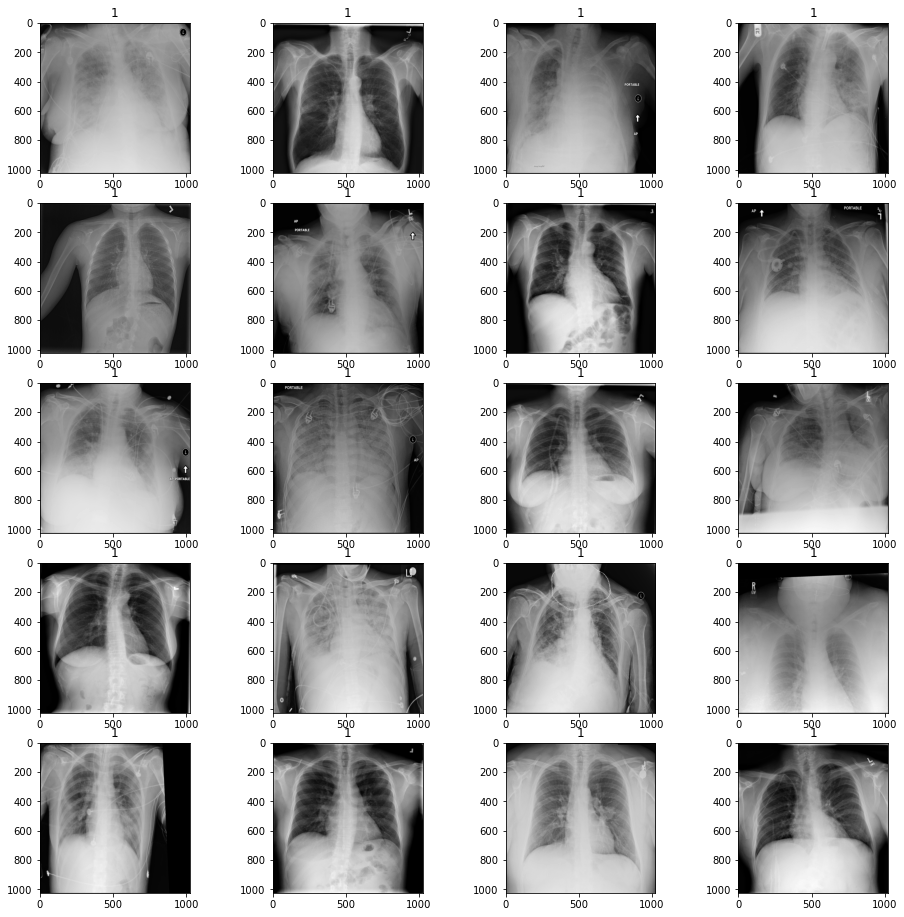

In [6]:
train_idg = ImageDataGenerator(rescale=1. / 255.0,
                          horizontal_flip =True , 
                              vertical_flip =False , 
                              height_shift_range = 0.33, 
                              width_shift_range = 0.24, 
                              rotation_range = 20 , 
                              shear_range = 0.22 ,
                              zoom_range= 0.13
                        )

train_gen = train_idg.flow_from_dataframe(dataframe=train_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 110
                                         )

val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )
    
    
val_gen = val_idg.flow_from_dataframe(dataframe=val_data, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 330)


all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda b: 'True' if b else 'False')

    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    
#    return my_train_idg


# def make_train_gen(train_gen):
    
    
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#    train_gen = my_train_idg.flow_from_dataframe(dataframe='pneumonia_class', 
#                                          directory=None, 
#                                          x_col = 'path',
#                                          y_col = 'Image Index',
#                                          class_mode = 'binary',
#                                          target_size = IMG_SIZE, 
#                                          batch_size = 10) 
#    return train_gen
        

#def make_val_gen(val_gen):
#    

#    val_gen = flow_from_dataframe(dataframe = val_df, 
#                                              directory=None, 
 #                                             x_col = 'path',
  #                                            y_col = 'pneumonia_class',
   #                                           class_mode = 'binary',
    #                                          target_size = IMG_SIZE, 
     #                                         batch_size = 32) 
    #
#    return val_gen
from skimage import io

fig, m_axs = plt.subplots(5,4, figsize = (16, 16))
m_axs = m_axs.flatten()
imgs = train_data.path
ind=0

for img, ax in zip(imgs, m_axs):
    img = io.imread(img)
    ax.imshow(img,cmap='gray')
    ax.set_title(train_data.iloc[ind]['pneumonia_class'])
    ind=ind+1



In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:

valX, valY = val_gen.next()

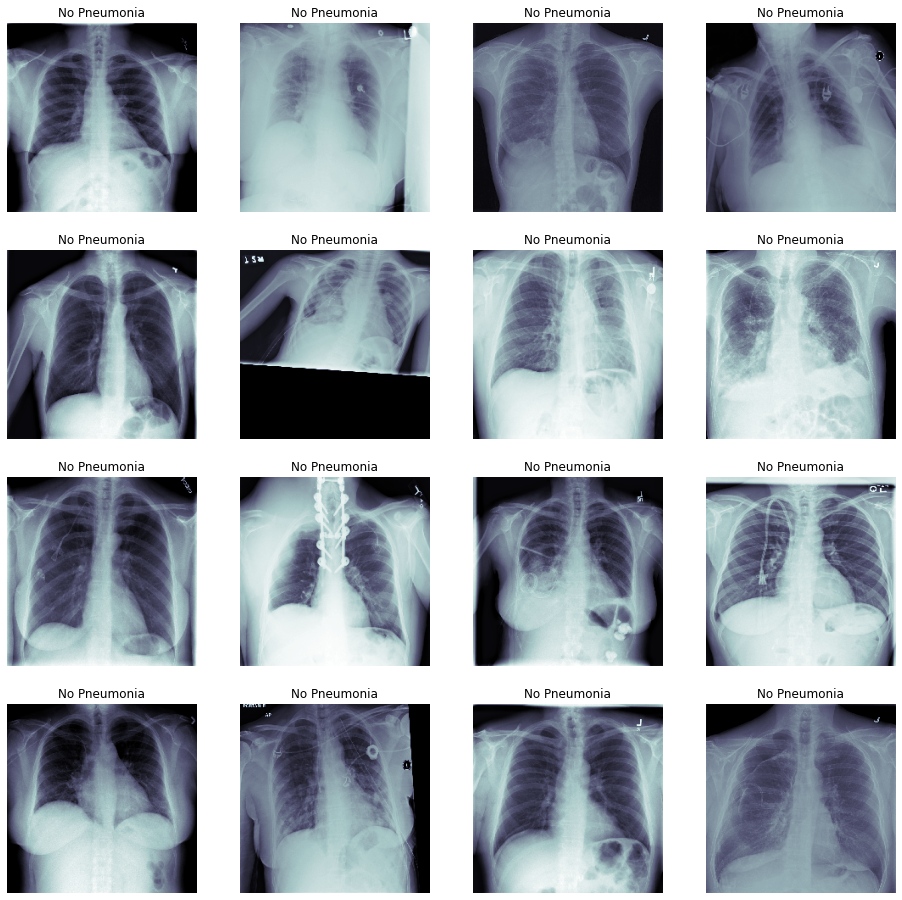

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(val_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
# def load_pretrained_model(model, transfer_layer, vgg_model):
    
    
   # model = VGG16(include_top=True, weights='imagenet')
   # transfer_layer = model.get_layer(lay_of_interest)
    # vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    
   # return vgg_model

model = VGG16(include_top=True, weights='imagenet')
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)   

In [10]:
#def build_my_model(vargs):

from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

    
my_model = Sequential()
my_model.add(vgg_model)
my_model.add(Flatten())
my_model.add(Dropout(0.5))
my_model.add(Dense(1024, activation='relu'))
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))
             
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    #return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                            monitor= "val_accuracy",
                            verbose=1,
                            save_best_only=False,
                            save_weights_only=False,
                            mode="max",   
 )

early = EarlyStopping(monitor= "val_accuracy",
                      min_delta = 0.1,
                      mode= "max", 
                      baseline = None,
                      patience=3)

callbacks_list = [checkpoint, early]

### Start training! 

In [12]:
## train your model

# Todo

my_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
optimizer = Adam(lr = 0.08, beta_1 = 0.93, beta_2 = 0.999,
  epsilon = None, decay = 0, amsgrad = False, clipnorm = None,
  clipvalue = None)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']
history = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs = 14, 
                          callbacks = callbacks_list)



Epoch 1/14
18/18 [==============================] - 89s 5s/step - loss: 1.1970 - accuracy: 0.5125 - val_loss: 0.6779 - val_accuracy: 0.9879

Epoch 00001: saving model to xray_class_my_model.best.hdf5
Epoch 2/14
18/18 [==============================] - 55s 3s/step - loss: 0.6953 - accuracy: 0.5000 - val_loss: 0.6764 - val_accuracy: 0.9879

Epoch 00002: saving model to xray_class_my_model.best.hdf5
Epoch 3/14
18/18 [==============================] - 54s 3s/step - loss: 0.7468 - accuracy: 0.4979 - val_loss: 0.6953 - val_accuracy: 0.2909

Epoch 00003: saving model to xray_class_my_model.best.hdf5
Epoch 4/14
18/18 [==============================] - 55s 3s/step - loss: 0.7330 - accuracy: 0.4891 - val_loss: 0.4903 - val_accuracy: 0.9879

Epoch 00004: saving model to xray_class_my_model.best.hdf5


##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
new_model = "xray_class_my_model.best.hfd5" 
pred_Y = my_model.predict(valX, batch_size = 65, verbose = True)
valY

330/330 [==============================] - 9s 28ms/step


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [27]:
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return plot_roc_curve
    
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (10, 10))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

def F1_score(precision, recall):
    return (2 * (precision * recall) / (precision + recall))

precision, recall, thresholds = precision_recall_curve(valY, pred_Y) 
F1_scores = F1_score(precision, recall)
    

def plot_history(history):
    
    # Todo
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="train_accuracy")
    plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_accuracy")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch Count")
    plt.ylabel("Loss vs Accuracy")
    plt.legend(loc = "upper right")
    
    return plot_history 

max_F1_score = np.max(F1_score(precision, recall))
F1_score(precision, recall)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


array([0.04347826, 0.03278689, 0.03296703, 0.03314917, 0.03333333,
       0.03351955, 0.03370787, 0.02259887, 0.02272727, 0.02285714,
       0.02298851, 0.02312139, 0.02325581, 0.02339181, 0.02352941,
       0.02366864, 0.02380952, 0.0239521 , 0.02409639, 0.02424242,
       0.02439024, 0.02453988, 0.01234568, 0.01242236,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        

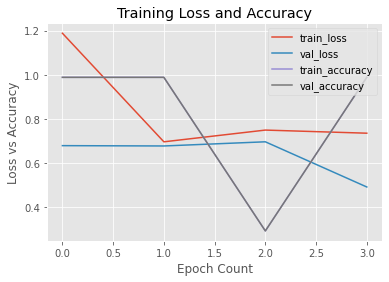

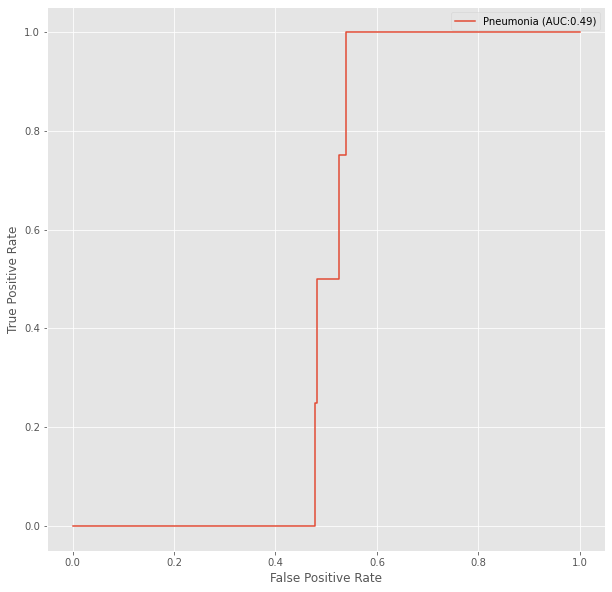

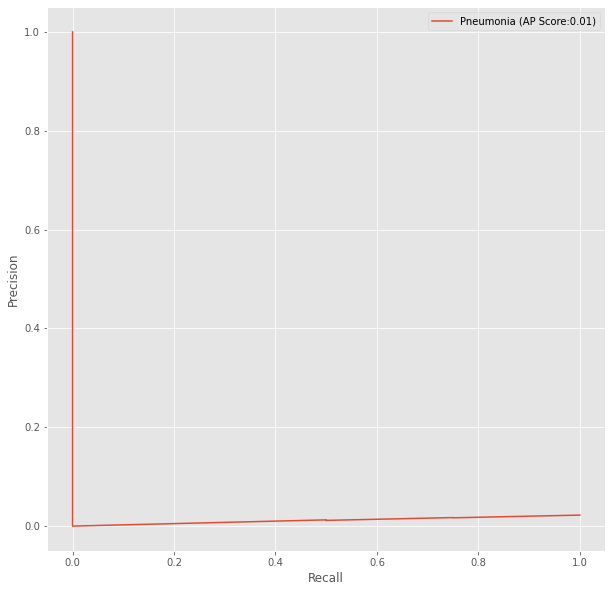

In [26]:
plot_history(history)
plot_roc_curve(valY,pred_Y)
plot_precision_recall_curve(valY,pred_Y)


Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [16]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

THRESHOLD = F1_score(precision, recall)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in greater
  from ipykernel import kernelapp as app


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

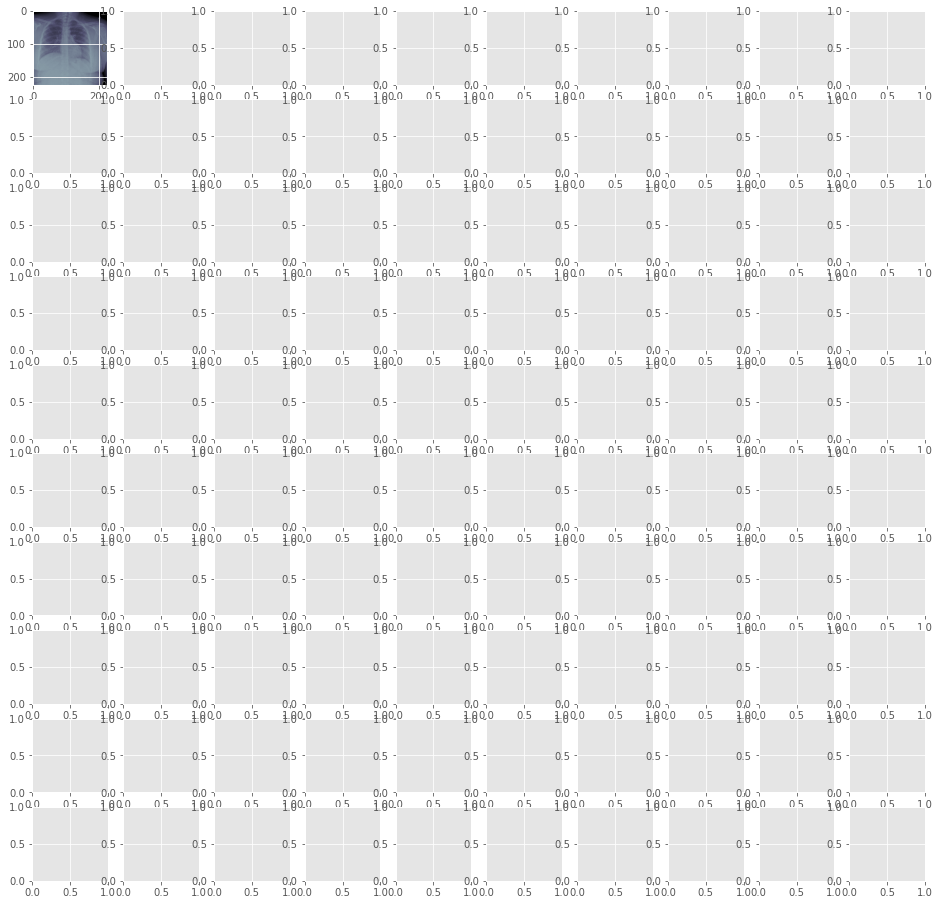

In [17]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:300], valY[0:300], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1:
        if pred_Y[i] > THRESHOLD1:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > THRESHOLD:
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.set_title('0, 0')
    i=i+1

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)